# Notebook d'entrainement et de test du modèle de segmentation sémantiques des images de Parking Libre

Pour pouvoir entrainer le modèle U_NET11 fourni par la librairie [Ternausnet](https://pypi.org/project/ternausnet/), nous avons eu besoin d'utiliser des ressources GPU. Pour ce faire nous avons utiliser Google Collab et avons donc besoin de synchroniser l'environnement Google Collab avec notre Drive Partagé afin de pouvoir accéder aux données.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#pip install ternausnet

##  1. Import des librairies nécessaires

In [3]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import ternausnet.models
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from tqdm import tqdm
from collections import defaultdict

## 2. Configuration de l'environnement

### 2.1 Test de la disponibilité d'un GPU compatible avec Pytorch

In [4]:
if torch.cuda.is_available():
    print("Un GPU compatible CUDA a été détecté.")
else:
    print("Aucun GPU compatible CUDA n'a été détecté. Il vaut certainement mieux utiliser une instance de Google Colab")


Aucun GPU compatible CUDA n'a été détecté. Il vaut certainement mieux utiliser une instance de Google Colab


### 2.2 Définition de classes utilitaires

In [5]:
class DataReader:
    """
    A helper class to read image and mask data from specified paths.
    """
    @staticmethod
    def read_data(image_path, mask_path=None):
        """
        Reads an image and its corresponding mask from the given file paths.
        Args:
            image_path (str): Path to the image file.
            mask_path (str): Path to the mask file.
        Returns:
            tuple: A tuple containing the original image and mask as numpy arrays.
        """
        image = cv2.imread(image_path)
        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if mask_path :
          original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
          return original_image, original_mask
        else:
          return original_image, None


def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 255.0] = 1.0
    return mask


class Visualizer:
    """
    A helper class for visualizing images and masks.
    """
    @staticmethod
    def visualize(image, mask, original_image=None, original_mask=None, title=None):
        """
        Visualizes the original and transformed images and masks.
        Args:
            image (numpy.ndarray): Transformed image to be visualized.
            mask (numpy.ndarray): Transformed mask to be visualized.
            original_image (numpy.ndarray, optional): Original image for comparison.
            original_mask (numpy.ndarray, optional): Original mask for comparison.
            title (str, optional): Title for the visualization plot.
        """
        fontsize = 18
        if original_image is None and original_mask is None:
            f, ax = plt.subplots(2, 1, figsize=(8, 8))
            ax[0].imshow(image)
            ax[1].imshow(mask)
        else:
            f, ax = plt.subplots(2, 2, figsize=(8, 8))
            f.suptitle(title, fontsize=fontsize)
            ax[0, 0].imshow(original_image)
            ax[0, 0].set_title('Original image', fontsize=fontsize)
            ax[1, 0].imshow(original_mask)
            ax[1, 0].set_title('Original mask', fontsize=fontsize)
            ax[0, 1].imshow(image)
            ax[0, 1].set_title('Transformed image', fontsize=fontsize)
            ax[1, 1].imshow(mask)
            ax[1, 1].set_title('Transformed mask', fontsize=fontsize)


    @staticmethod
    def visualize_batch(data_loader):
        """
        Visualizes the first three images and masks from the given data loader.

        Args:
            data_loader (DataLoader): A PyTorch DataLoader object containing images and masks.
        """
        fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # 3 rows, 2 columns
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        mean = mean[:, None, None]
        std = std[:, None, None]
        for i, (images, masks) in enumerate(data_loader):
            if i == 3:  # Only show first 3 images and masks
                break

            axs[i, 0].imshow((torch.clamp((images[i]*std+mean).permute(1, 2, 0), 0, 1)*255).numpy().astype(np.uint8))  # Change CxHxW to HxWxC
            axs[i, 0].set_title(f'Image {i}')
            axs[i, 0].axis('off')

            axs[i, 1].imshow(masks[i], cmap='gray')
            axs[i, 1].set_title(f'Mask {i} & Pourcentage of parking : {masks[i][masks[i]==1.0].shape[0]/(256*256)}')
            axs[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
        cols = 3 if predicted_masks else 2
        rows = len(images_filenames)
        figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
        for i, image_filename in enumerate(images_filenames):
            image = cv2.imread(os.path.join(images_directory, image_filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".png", "_mask.png")), cv2.IMREAD_GRAYSCALE)
            mask = preprocess_mask(mask)
            ax[i, 0].imshow(image)
            ax[i, 1].imshow(mask, interpolation="nearest")

            ax[i, 0].set_title("Image")
            ax[i, 1].set_title("Ground truth mask")

            ax[i, 0].set_axis_off()
            ax[i, 1].set_axis_off()

            if predicted_masks:
                predicted_mask = predicted_masks[i]
                ax[i, 2].imshow(predicted_mask, interpolation="nearest")
                ax[i, 2].set_title("Predicted mask")
                ax[i, 2].set_axis_off()
        plt.tight_layout()
        plt.show()


### 2.3 Définition des classes afin de créer les datasets

In [6]:
class FreeParkingPlacesDataset(Dataset):
    def __init__(self, images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.images_filenames = os.listdir(images_directory)
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image_path = os.path.join(self.images_directory, image_filename)
        mask_path = os.path.join(self.masks_directory, image_filename.replace(".png", '_mask.png'))
        image, mask = DataReader.read_data(image_path, mask_path)
        mask = self.preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

    def preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask == 255.0] = 1.0
        return mask

In [7]:
class FreeParkingPlacesInferenceDataset(Dataset):
    def __init__(self, images_directory, transform=None):
        self.images_directory = images_directory
        self.images_filenames = os.listdir(images_directory)
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image_path = os.path.join(self.images_directory, image_filename)
        image, _ = DataReader.read_data(image_path)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

    def preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask == 255.0] = 1.0
        return mask

### 2.4 Constants & Helper Entities definitions

In [8]:
visualizer_batch_size = 4
visualizer_worker = Visualizer()

# training_image_dir = "./drive/MyDrive/ML_with_Python_Project_Segmentation/data/train/images/"
# training_mask_dir = "./drive/MyDrive/ML_with_Python_Project_Segmentation/data/train/masks/"

# val_image_dir = "./drive/MyDrive/ML_with_Python_Project_Segmentation/data/val/images/"
# val_mask_dir = "./drive/MyDrive/ML_with_Python_Project_Segmentation/data/val/masks/"

# test_image_dir = "./drive/MyDrive/ML_with_Python_Project_Segmentation/data/test/images/"
# test_mask_dir = "./drive/MyDrive/ML_with_Python_Project_Segmentation/data/test/masks/"
# test_image_filenames = os.listdir("./drive/MyDrive/ML_with_Python_Project_Segmentation/data/test/images/")

training_image_dir = "../data/train/images/"
training_mask_dir = "../data/train/masks/"

val_image_dir = "../data/val/images/"
val_mask_dir = "../data/val/masks/"

test_image_dir = "../data/test/images/"
test_mask_dir = "../data/test/masks/"
test_image_filenames = os.listdir("../data/test/images/")


params = {
    "model": "UNet11",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "lr": 0.003,
    "class_weights": [1.0, 3.0],
    "batch_size": 16,
    # "num_workers": 4,
    "epochs": 25,
}

### 2.5 Definition of Training & Validation DataSets

In [9]:
training_ds = FreeParkingPlacesDataset(
    images_directory=training_image_dir,
    masks_directory=training_mask_dir,
    transform=A.Compose([
#         A.Resize(height=256, width=256, p=1), # Needed because all images do not have the same size. Will be deleted !
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        ToTensorV2()])
)

validation_ds = FreeParkingPlacesDataset(
    images_directory=val_image_dir,
    masks_directory=val_mask_dir,
    transform=A.Compose([
#         A.Resize(height=256, width=256, p=1), # Needed because all images do not have the same size. Will be deleted !
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        ToTensorV2()])
)

train_loader = DataLoader(training_ds, batch_size=visualizer_batch_size, shuffle=True)
val_loader = DataLoader(validation_ds, batch_size=visualizer_batch_size, shuffle=False)

#### Visualisation des données dans le DataSet de Training

Pour le masque, nous avons décidé d'afficher également le pourcentage de pixels représentant les places de parking pour avoir une idée de la proportion de labels 1 et 0.

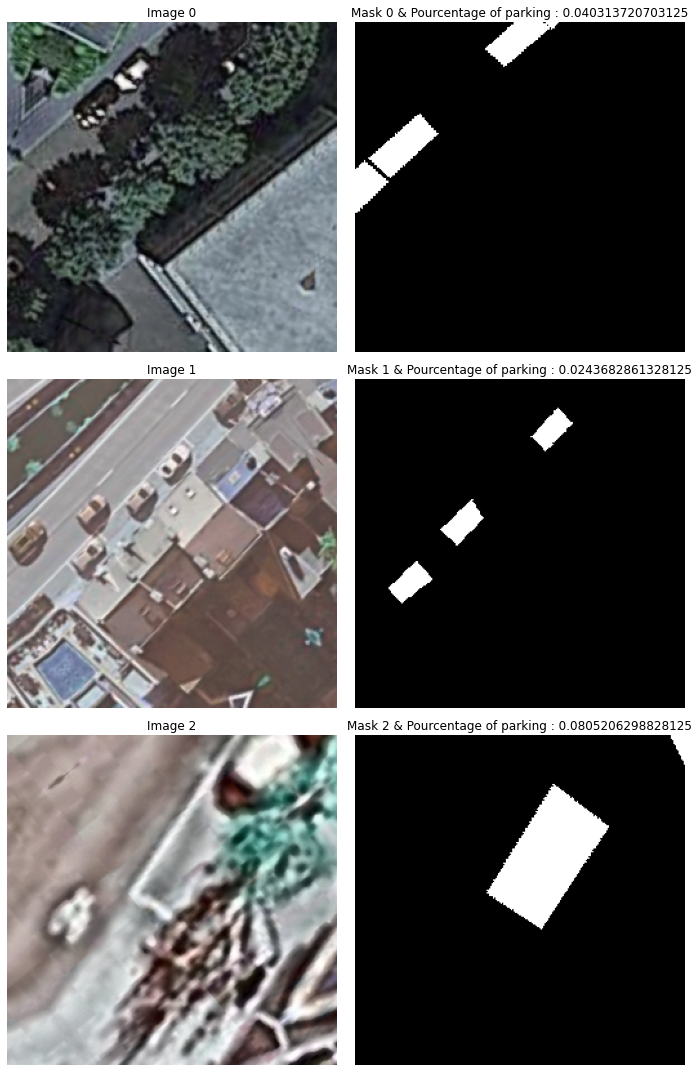

In [10]:
visualizer_worker.visualize_batch(train_loader)

#### Visualisation des données dans le DataSet de Validation

Pour le masque, nous avons également décidé d'afficher le pourcentage de pixels représentant les places de parking pour avoir une idée de la proportion de labels 1 et 0.

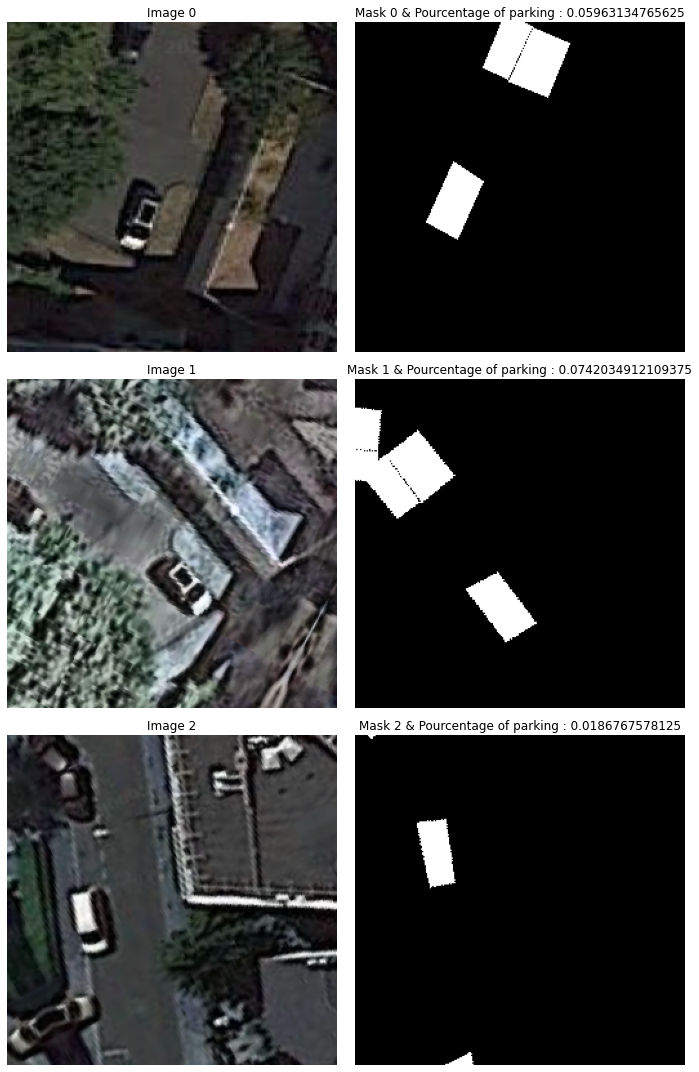

In [11]:
visualizer_worker.visualize_batch(val_loader)

#### Visualisation des données dans le DataSet de Test

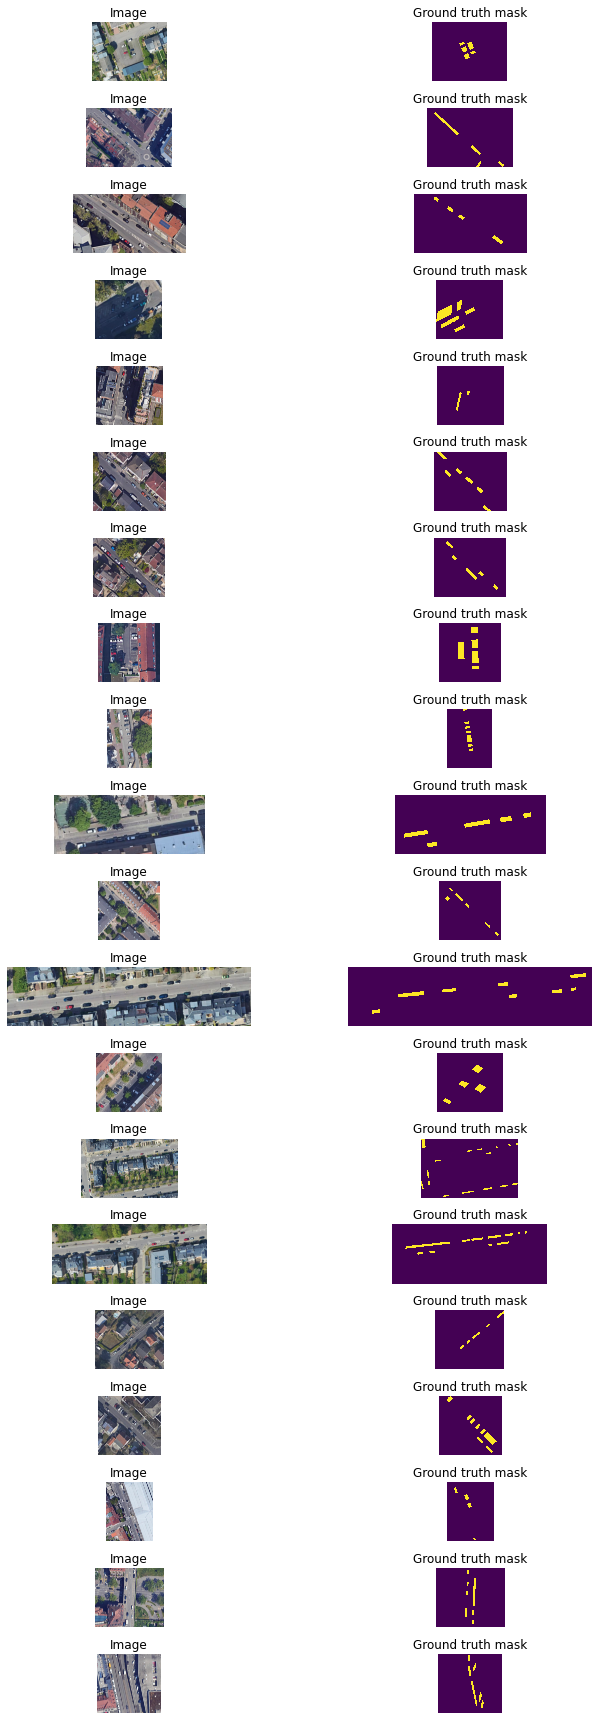

In [12]:
visualizer_worker.display_image_grid(test_image_filenames, test_image_dir, test_mask_dir)

## 3. Définition et Entrainement du model U_Net11

### 3.1 Classes et Fonctions utilitaires

In [13]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update(f"{criterion.__class__()}", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update(f"{criterion.__class__()}", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [14]:
def train_and_validate(model, train_dataset, val_dataset, params):
    # Initialize DataLoaders for training and validation datasets
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
    )

    # We introduce Weigth in the loss because parking place class is under represented
    criterion = nn.BCEWithLogitsLoss(pos_weight=10*torch.ones([256])).to(params["device"])


    # Initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

    # Training and validation loop
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)

    return model

def predict(model, params, test_dataset, batch_size):
    # Initialize DataLoader for the test dataset
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
    )

    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients for predictions
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()

            # Process predictions
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))

    return predictions

In [15]:
def create_model():
    model = getattr(ternausnet.models, "UNet11")(pretrained=False)
    model = model.to("cuda")
    return model


def load_model(model_file_path):
    model = getattr(ternausnet.models, "UNet11")(pretrained=False)
    model.load_state_dict(torch.load(model_file_path, map_location=params['device']))
    model = model.to(params['device'])
    return model

### 3.2 Entrainement et sauvegarde d'un modèle U_Net11

#### Initialisation du modèle

In [16]:
# model = create_model()

#### Initialisation des paramètre de la boucle d'entrainement

In [17]:
# all_params = [{
#     "model": "UNet11",
#     "device": "cuda",
#     "lr": 0.01,
#     "class_weights": [1.0, 3.0],
#     "batch_size": 64,
#     # "num_workers": 4,
#     "epochs": 5,
# },
#               {
#     "model": "UNet11",
#     "device": "cuda",
#     "lr": 0.003,
#     "class_weights": [1.0, 3.0],
#     "batch_size": 64,
#     # "num_workers": 4,
#     "epochs": 5,
# },
#               {
#     "model": "UNet11",
#     "device": "cuda",
#     "lr": 0.001,
#     "class_weights": [1.0, 3.0],
#     "batch_size": 64,
#     # "num_workers": 4,
#     "epochs": 5,
# },
#  {
#     "model": "UNet11",
#     "device": "cuda",
#     "lr": 0.001,
#     "class_weights": [1.0, 3.0],
#     "batch_size": 32,
#     # "num_workers": 4,
#     "epochs": 5,
# },
# {
#     "model": "UNet11",
#     "device": "cuda",
#     "lr": 0.001,
#     "class_weights": [1.0, 3.0],
#     "batch_size": 16,
#     # "num_workers": 4,
#     "epochs": 5,
# }]

#### Entrainement et sauvegarde

In [18]:
# for params in all_params:
#     model = train_and_validate(model, training_ds, validation_ds, params)


# torch.save(model.state_dict(), "./drive/MyDrive/ML_with_Python_Project_Segmentation/cross_entropy_weighted10_batch64_32_16_lr_01_001_0001.pth")

### 3.3 Réutilisation d'un modèle sauvegardé

In [20]:
path_to_saved_model = "./cross_entropy_weighted10_batch64_32_16.pth"

model = load_model(path_to_saved_model)

C:\Users\maxim\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maxim\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 4. Test du modèle sur le jeu de test

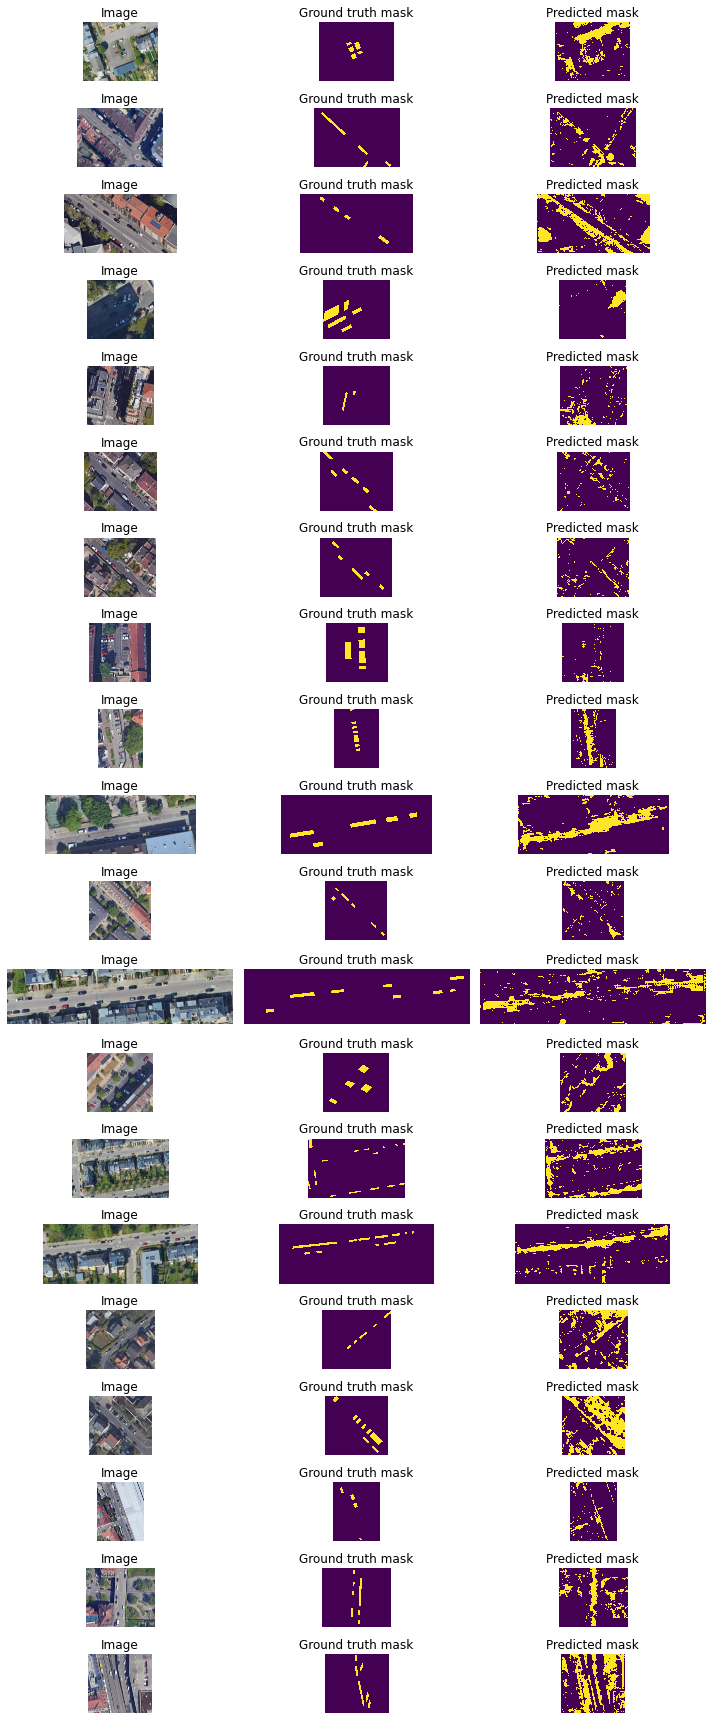

In [21]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = FreeParkingPlacesInferenceDataset(test_image_dir, transform=test_transform)

predictions = predict(model, params, test_dataset, batch_size=16)

predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

visualizer_worker.display_image_grid(test_image_filenames, test_image_dir, test_mask_dir, predicted_masks=predicted_masks)